# Experiment: Water Management Strategies: Irrigation

One of the possibilities that countries which face high water stress could have to reduce their stress, is to irrigate their crops with treated municipal water or even untreated municipal water.

To test this, we define our Null-Hypothesis $H_0$ that there is no difference between the water source that is used for irrigation in countries with high water stress.

The test we use is a chi-square independence test.

In [7]:
from tueplots import bundles, figsizes
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import os
sys.path.insert(1, os.path.abspath(os.getcwd()[:-3]))

plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update(bundles.icml2022(column="half"))
plt.rcParams.update({"figure.dpi": 200})

In [8]:
from src.aquastat_utils import get_aquastat

# Get the aquastat data
aquastat_df = get_aquastat()

Getting AQUASTAT dataframe from fao_aquastat.csv ...
/Users/josef/Sync/Dokumente/SCHULE/Master/UT/Vorlesungen/Sem2/Data_Literacy/Paper/src/../dat/fao_aquastat.csv already exists.
Renaming countries ...


In [9]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency

# Prepare the data
irrigation_types = [
    'Area equipped for irrigation by direct use of not treated municipal wastewater',
    'Area equipped for irrigation by direct use of treated municipal wastewater',
    'Area equipped for irrigation by mixed surface water and groundwater',
]

years = [2014, 2015, 2016, 2017, 2018, 2019, 2020]
results = []
for year in years:
    irrigation_df = aquastat_df[irrigation_types +
                                ['Year', 'SDG 6.4.2. Water Stress']].copy()
    irrigation_df = irrigation_df[irrigation_df['Year'] == year]

    # Move 'Area equipped for irrigation by direct use of non-treated municipal wastewater ' to 'Area equipped for irrigation by direct use of not treated municipal wastewater'
    irrigation_df['Area equipped for irrigation by direct use of not treated municipal wastewater'] += aquastat_df['Area equipped for irrigation by direct use of non-treated municipal wastewater ']

    # Normalize the irrigated area by the total area
    irrigation_df['Total Area'] = aquastat_df['Area equipped for irrigation: total']
    for irrigation_type in irrigation_types:
        irrigation_df[irrigation_type] = irrigation_df[irrigation_type] / \
            irrigation_df['Total Area']

    # Categories for water stress
    water_stress_bins = [0, 20, 40, 100]
    irrigation_df['Water Stress Category'] = pd.cut(
        irrigation_df['SDG 6.4.2. Water Stress'], bins=water_stress_bins, labels=[
            'Low', 'Medium', 'High']
    )

    # Create contingency table
    categories = ['Low', 'Medium', 'High']
    contingency_table = pd.DataFrame(
        0, columns=irrigation_types, index=categories)

    # Count the number of countries in each category
    for category in categories:
        for irrigation_type in irrigation_types:
            count = irrigation_df[(irrigation_df['Water Stress Category'] == category) & (
                irrigation_df[irrigation_type] > 0)].shape[0]
            contingency_table.at[category, irrigation_type] = count

    # Chi-Quadrat-Test
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    results.append([year, chi2, p, dof, expected])

    # Print results for every year
    print(f'Year: {year}')
    print(f'Chi-square Statistic: {chi2}, p-value: {p}')
    for i, category in enumerate(categories):
        print(f'{category} water stress:')
        for j, irrigation_type in enumerate(irrigation_types):
            print(
                f'\t{irrigation_type}: {expected[i, j]:.2f} ({contingency_table.at[category, irrigation_type]})')
        print()
    print('=========' * 5)

Year: 2014
Chi-square Statistic: 2.963719357565511, p-value: 0.5639151234524952
Low water stress:
	Area equipped for irrigation by direct use of not treated municipal wastewater: 5.35 (6)
	Area equipped for irrigation by direct use of treated municipal wastewater: 10.29 (8)
	Area equipped for irrigation by mixed surface water and groundwater: 5.35 (7)

Medium water stress:
	Area equipped for irrigation by direct use of not treated municipal wastewater: 4.33 (3)
	Area equipped for irrigation by direct use of treated municipal wastewater: 8.33 (11)
	Area equipped for irrigation by mixed surface water and groundwater: 4.33 (3)

High water stress:
	Area equipped for irrigation by direct use of not treated municipal wastewater: 3.31 (4)
	Area equipped for irrigation by direct use of treated municipal wastewater: 6.37 (6)
	Area equipped for irrigation by mixed surface water and groundwater: 3.31 (3)

Year: 2015
Chi-square Statistic: 3.2395208083233293, p-value: 0.5185714085623199
Low water s

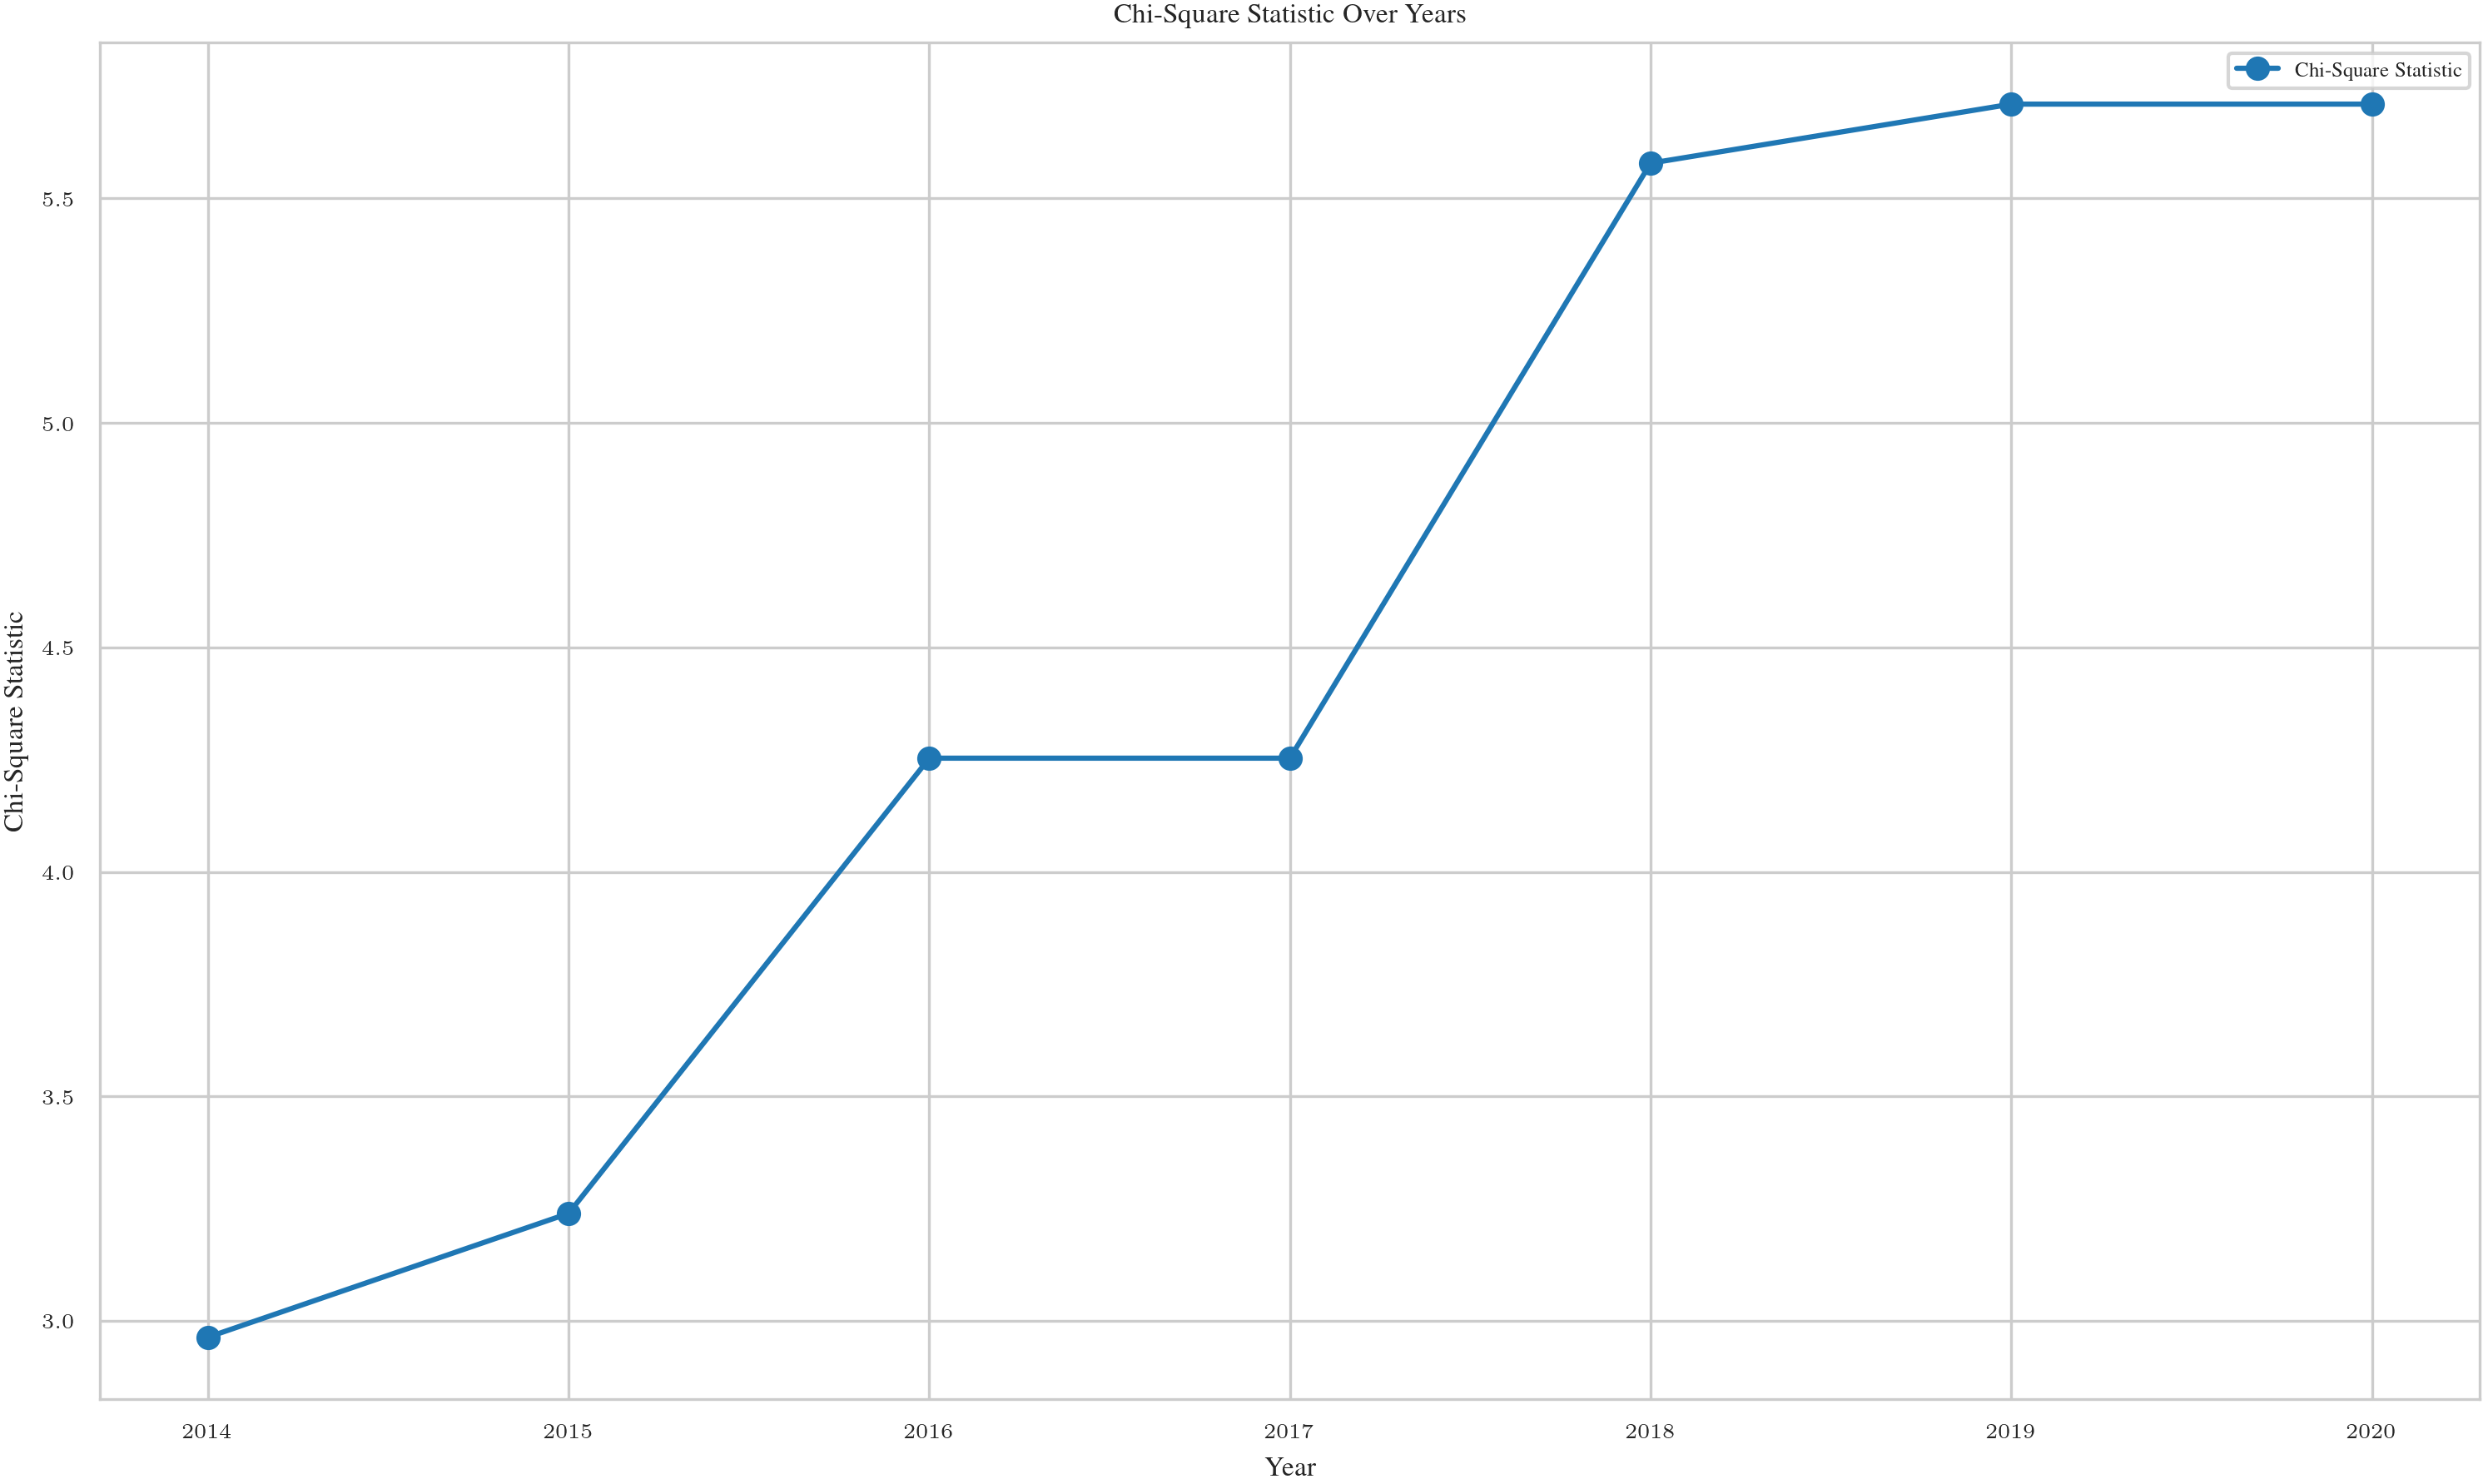

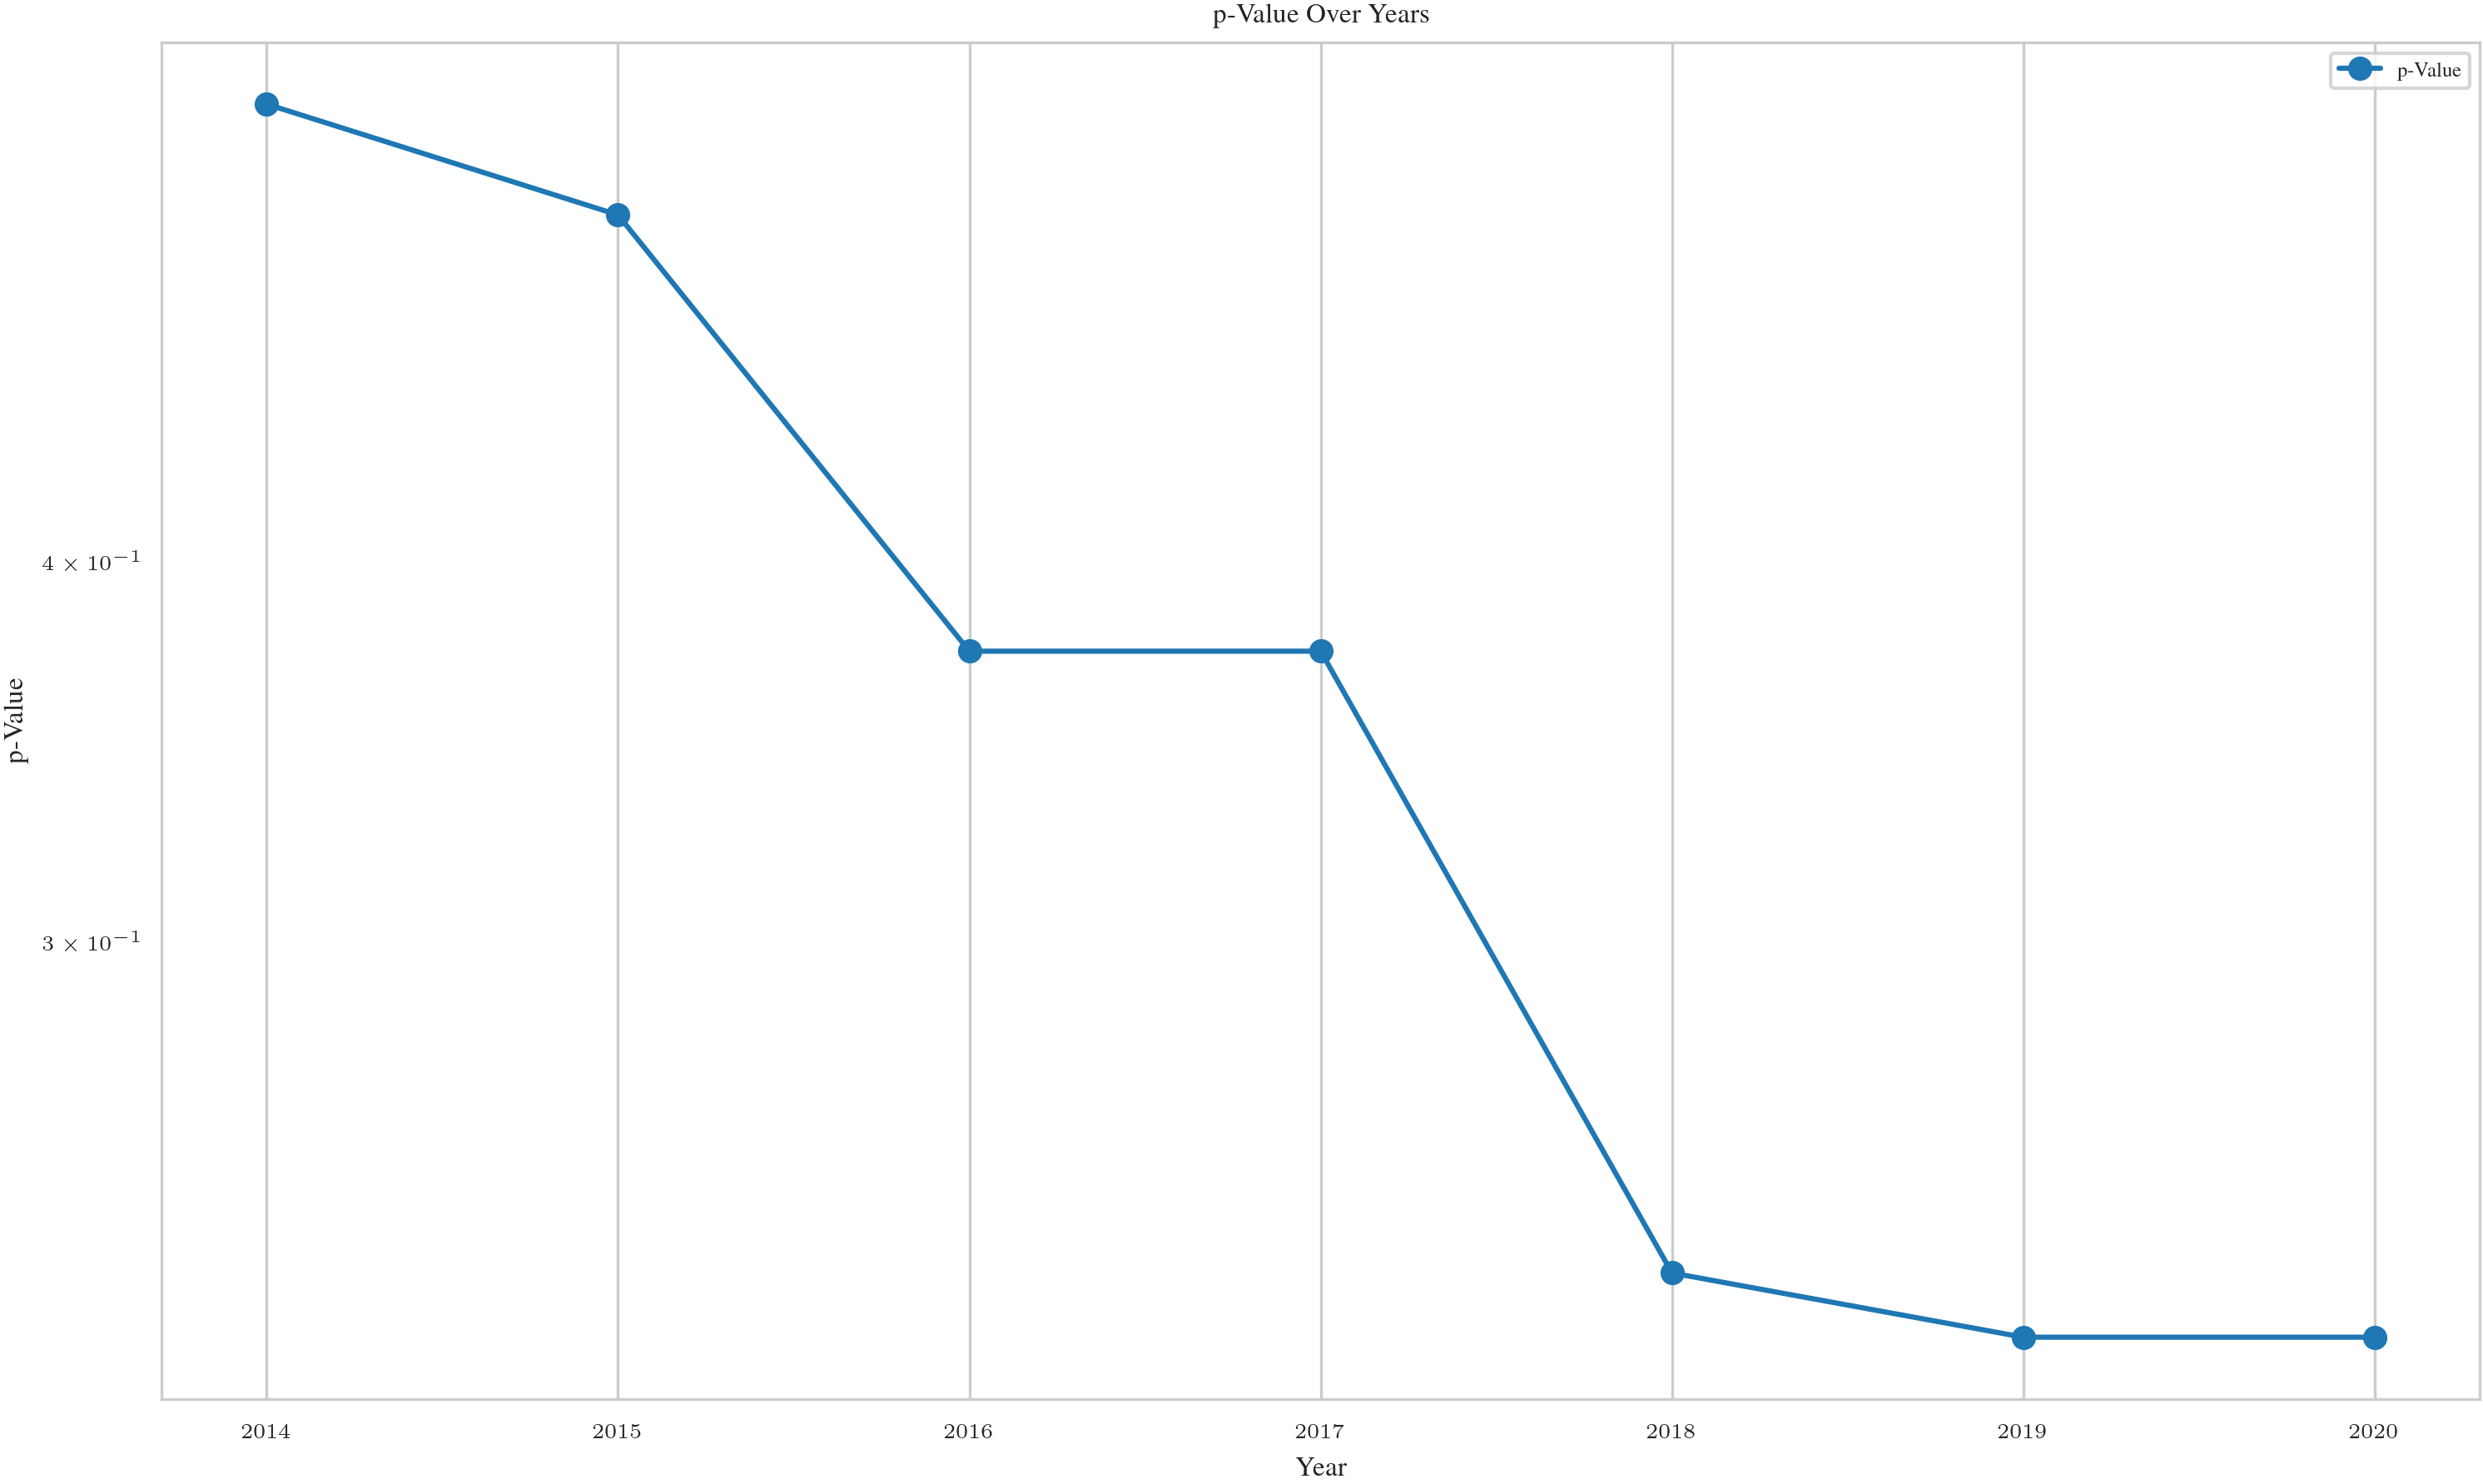

In [13]:
import matplotlib.pyplot as plt

# Konvertieren der Ergebnisse in einen DataFrame
results_df = pd.DataFrame(results, columns=['Year', 'Chi-Square', 'p-Value', 'dof', 'Expected'])

# Plotten der Chi-Quadrat-Statistik über die Jahre
plt.figure(figsize=(10, 6))
plt.plot(results_df['Year'], results_df['Chi-Square'], marker='o', label='Chi-Square Statistic')
plt.title('Chi-Square Statistic Over Years')
plt.xlabel('Year')
plt.ylabel('Chi-Square Statistic')
plt.grid(True)
plt.legend()
plt.show()

# Plotten der p-Werte über die Jahre
plt.figure(figsize=(10, 6))
plt.plot(results_df['Year'], results_df['p-Value'], marker='o', label='p-Value')
plt.title('p-Value Over Years')
plt.xlabel('Year')
plt.ylabel('p-Value')
plt.yscale('log')  # Logarithmische Skala, da p-Werte oft sehr klein sind
plt.grid(True)
plt.legend()
plt.show()
